In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib qt

In [2]:
import os
import sys
from pathlib import Path
sys.path.insert(1, str(Path(os.getcwd()).parent / "src"))

In [3]:
import numpy as np
import pmcx
from matplotlib import pyplot as plt
import os
import io
from pathlib import Path
import data_loader
from scipy import interpolate
from tqdm import tqdm
import config

In [4]:
pmcx.gpuinfo()

=============================   GPU Information  ================================
Device 1 of 1:		NVIDIA GeForce GTX 1050
Compute Capability:	6.1
Global Memory:		4229824512 B
Constant Memory:	65536 B
Shared Memory:		49152 B
Registers:		65536
Clock Speed:		1.49 GHz
Number of SMs:		5
Number of Cores:	640
Auto-thread:		10240
Auto-block:		64


[{'name': 'NVIDIA GeForce GTX 1050',
  'id': 1,
  'devcount': 1,
  'major': 6,
  'minor': 1,
  'globalmem': 4229824512,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1493000,
  'sm': 5,
  'core': 640,
  'autoblock': 64,
  'autothread': 10240,
  'maxgate': 0}]

In [5]:
config.gpuid

1

In [6]:
config.dataset_dir

PosixPath('/media/leon/T7/IDP/dataset/HELICoiD/HSI_Human_Brain_Database_IEEE_Access')

In [7]:
config.pl_dir

PosixPath('/media/leon/Storage/Studium/Informatik/Master/3.Semester/IDP/nonlinear-fit/dataset/mc_pl_simulations')

In [8]:
sample_wavelengths = np.arange(450, 960, 10)
dense_wavelengths = np.arange(sample_wavelengths[0], sample_wavelengths[-1] + 1)
print(sample_wavelengths)

[450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620
 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800
 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950]


### Compute pathlength for gray matter

In [ ]:
g_gm = 0.85
refractive_idx_gm = 1.36
mu_a_vals_gm = data_loader.DataLoader.mu_a_func_gray_matter(sample_wavelengths) / 10
mu_s_vals_gm = data_loader.DataLoader.mu_s_red_func_gray_matter(sample_wavelengths) / 10 / (1-g_gm)

In [9]:
prop = np.array([[0,0,1,1],[0,0,g_gm,refractive_idx_gm]])
vol = np.ones((100, 100, 120), dtype="uint8")

cfg = {
    "nphoton": 1e7,
    "maxdetphoton": 1e7,
    "vol": vol,
    "tstart":0,
    "tend":5e-7,
    "tstep":5e-7,
    "autopilot": 1,
    "gpuid": 5,#config.gpuid,
    "prop": prop,
    "bc": "ccrcca001000",
    "isspecular": 1, # should not have effect without 0-voxels
    "srcdir": [0,0,1],
    "srctype": "planar",
    "srcpos": [0, 0, 0],
    "srcparam1": [vol.shape[0], 0, 0, 0], # 3D position of vertex, fourth coordinate is irrelevant
    "srcparam2": [0, vol.shape[1], 0, 0],
    "issrcfrom0": 1,
    "savedetflag": "dsp",
    "flog": str(config.pl_dir) + "/log.txt"
}

#one layer of air
#cfg["vol"][:, :, 0] = 0

NameError: name 'g_gm' is not defined

In [ ]:
# empty log file
open(config.pl_dir / "log.txt", "w").close()
header_sim = "wavelength mu_a mu_s diffuse-reflectance pathlength meanscat"
# empty PL file and write header
with open(config.pl_dir / "gray_matter_mcs.txt", "w") as f:
    f.write("# " + header_sim + "\n")

data_gray_matter_mcs = np.empty((len(sample_wavelengths), 6), dtype="float") # per wavelength: wavelength, mu_a, mu_s (1/mm), diffuse reflectance, pathlength (mm)

for i, (wl, mu_a, mu_s) in enumerate(zip(sample_wavelengths, mu_a_vals_gm, mu_s_vals_gm)):
    print(f"Simulating for {wl}nm...")
    cfg["prop"] = np.array([
        [0, 0, 1, 1],
        [mu_a, mu_s, g_gm, refractive_idx_gm],
    ])

    res = pmcx.mcxlab(cfg)

    if "detp" in res:
        detw = pmcx.utils.detweight(res["detp"])
        dref = np.sum(detw) / cfg["nphoton"]
        pl = pmcx.utils.meanpath(res["detp"])[0]
        scat = pmcx.utils.meanscat(res["detp"], cfg["prop"])
    else:
        dref, pl, scat = 0, np.nan, np.nan
        print(f"No detected photons for {wl}nm!\n prop values: {cfg['prop'][1]}")
        
    data_gray_matter_mcs[i, :] = np.array([wl, mu_a, mu_s, dref, pl, scat])

    with open(config.pl_dir / "gray_matter_mcs.txt", "ab") as f:
        np.savetxt(f, data_gray_matter_mcs[[i]])


Interpolate

In [ ]:
assert(np.all(np.diff(dense_wavelengths) > 0))
pl_gm_interpolated_linear = np.interp(dense_wavelengths, sample_wavelengths, data_gray_matter_mcs[:, 4])
pl_gm_spline_coefs = interpolate.splrep(sample_wavelengths, data_gray_matter_mcs[:, 4])
pl_gm_interpolated_spline = interpolate.splev(dense_wavelengths, pl_gm_spline_coefs)

Sava data to file

In [ ]:
header_interpolations = "wavelength pathlength"

np.savetxt(
    config.pl_dir / "gray_matter_pl_interpolated_linear.txt",
    np.row_stack((dense_wavelengths, pl_gm_interpolated_linear)).T,
    header=header_interpolations
)

np.savetxt(
    config.pl_dir / "gray_matter_pl_interpolated_spline.txt",
    np.row_stack((dense_wavelengths, pl_gm_interpolated_spline)).T,
    header=header_interpolations
)

Plot pathlength

In [ ]:
# Optional load values from file
data_gray_matter_mcs = np.loadtxt(config.pl_dir / "gray_matter_mcs.txt")
pl_gm_interpolated_linear = np.loadtxt(config.pl_dir / "gray_matter_pl_interpolated_linear.txt")[:, 1]
pl_gm_interpolated_spline = np.loadtxt(config.pl_dir / "gray_matter_pl_interpolated_spline.txt")[:, 1]

In [ ]:
plt.scatter(sample_wavelengths, data_gray_matter_mcs[:, -2])
plt.plot(dense_wavelengths, pl_gm_interpolated_linear)
plt.plot(dense_wavelengths, pl_gm_interpolated_spline)

### Compute pathlength for blood vessels

#### Compute pathlength for pure blood as tissue type

In [ ]:
g_bv = 0.935
refractive_idx_bv = 1.4
mu_s_vals_bv = data_loader.DataLoader.mu_s_red_func_blood_vessel(sample_wavelengths) / 10 / (1-g_bv)
mu_a_vals_bv = data_loader.DataLoader.mu_a_func_blood_vessel(sample_wavelengths) / 10

Config can stay the same...

In [ ]:
# empty log file
open(config.pl_dir / "log.txt", "w").close()
header_sim = "wavelength mu_a mu_s diffuse-reflectance pathlength meanscat"
# empty PL file and write header
with open(config.pl_dir / "blood_vessel_pure_mcs.txt", "w") as f:
    f.write("# " + header_sim + "\n")

data_blood_vessel_pure_mcs = np.empty((len(sample_wavelengths), 6), dtype="float") # per wavelength: wavelength, mu_a, mu_s (1/mm), diffuse reflectance, pathlength (mm)

for i, (wl, mu_a, mu_s) in enumerate(zip(sample_wavelengths, mu_a_vals_bv, mu_s_vals_bv)):
    print(f"Simulating for {wl}nm...")
    cfg["prop"] = np.array([
        [0, 0, 1, 1],
        [mu_a, mu_s, g_bv, refractive_idx_bv],
    ])

    res = pmcx.mcxlab(cfg)

    if "detp" in res:
        detw = pmcx.utils.detweight(res["detp"])
        dref = np.sum(detw) / cfg["nphoton"]
        pl = pmcx.utils.meanpath(res["detp"])[0]
        scat = pmcx.utils.meanscat(res["detp"], cfg["prop"])
    else:
        dref, pl, scat = 0, np.nan, np.nan
        print(f"No detected photons for {wl}nm!\n prop values: {cfg['prop'][1]}")
        
    data_blood_vessel_pure_mcs[i, :] = np.array([wl, mu_a, mu_s, dref, pl, scat])

    with open(config.pl_dir / "blood_vessel_pure_mcs.txt", "ab") as f:
        np.savetxt(f, data_blood_vessel_pure_mcs[[i]])


Interpolate

In [ ]:
assert(np.all(np.diff(dense_wavelengths) > 0))
pl_bv_pure_interpolated_linear = np.interp(dense_wavelengths, sample_wavelengths, data_blood_vessel_pure_mcs[:, -2])
pl_bv_pure_spline_coefs = interpolate.splrep(sample_wavelengths, data_blood_vessel_pure_mcs[:, -2])
pl_bv_pure_interpolated_spline = interpolate.splev(dense_wavelengths, pl_bv_pure_spline_coefs)

Save data to file

In [ ]:
header_interpolations = "wavelength pathlength"

np.savetxt(
    config.pl_dir / "blood_vessel_pure_pl_interpolated_linear.txt",
    np.row_stack((dense_wavelengths, pl_bv_pure_interpolated_linear)).T,
    header=header_interpolations
)

np.savetxt(
    config.pl_dir / "blood_vessel_pure_pl_interpolated_spline.txt",
    np.row_stack((dense_wavelengths, pl_bv_pure_interpolated_spline)).T,
    header=header_interpolations
)

Plot pathlenghts

In [ ]:
# Optional load values from file
data_blood_vessel_pure_mcs = np.loadtxt(config.pl_dir / "blood_vessel_pure_mcs.txt")
pl_bv_pure_interpolated_linear = np.loadtxt(config.pl_dir / "blood_vessel_pure_pl_interpolated_linear.txt")[:, 1]
pl_bv_pure_interpolated_spline = np.loadtxt(config.pl_dir / "blood_vessel_pure_pl_interpolated_spline.txt")[:, 1]

In [ ]:
plt.scatter(sample_wavelengths, data_blood_vessel_pure_mcs[:, -2])
plt.plot(dense_wavelengths, pl_bv_pure_interpolated_linear)
plt.plot(dense_wavelengths, pl_bv_pure_interpolated_spline)
plt.plot(dense_wavelengths, pl_gm_interpolated_linear)

#### Compute pathlength for tumor tissue

In [9]:
g_t = data_loader.DataLoader.tissue_parameters["tumor"][2]
refractive_idx_t = data_loader.DataLoader.tissue_parameters["tumor"][3]
mu_s_vals_t = data_loader.DataLoader.mu_s_red_func_tissue(sample_wavelengths, "tumor") / 10 / (1-g_t)
mu_a_vals_t = data_loader.DataLoader.mu_a_func_tissue(sample_wavelengths, "tumor") / 10

In [ ]:
# empty log file
open(config.pl_dir / "log.txt", "w").close()
header_sim = "wavelength mu_a mu_s diffuse-reflectance pathlength meanscat"
# empty PL file and write header
with open(config.pl_dir / "tumor_mcs.txt", "w") as f:
    f.write("# " + header_sim + "\n")

tumor_mcs = np.empty((len(sample_wavelengths), 6), dtype="float") # per wavelength: wavelength, mu_a, mu_s (1/mm), diffuse reflectance, pathlength (mm)

for i, (wl, mu_a, mu_s) in enumerate(zip(sample_wavelengths, mu_a_vals_t, mu_s_vals_t)):
    print(f"Simulating for {wl}nm...")
    cfg["prop"] = np.array([
        [0, 0, 1, 1],
        [mu_a, mu_s, g_t, refractive_idx_t],
    ])

    res = pmcx.mcxlab(cfg)

    if "detp" in res:
        detw = pmcx.utils.detweight(res["detp"])
        dref = np.sum(detw) / cfg["nphoton"]
        pl = pmcx.utils.meanpath(res["detp"])[0]
        scat = pmcx.utils.meanscat(res["detp"], cfg["prop"])
    else:
        dref, pl, scat = 0, np.nan, np.nan
        print(f"No detected photons for {wl}nm!\n prop values: {cfg['prop'][1]}")
        
    tumor_mcs[i, :] = np.array([wl, mu_a, mu_s, dref, pl, scat])

    with open(config.pl_dir / "tumor_mcs.txt", "ab") as f:
        np.savetxt(f, tumor_mcs[[i]])


In [10]:
gray_matter_mcs_pathlength_data = np.loadtxt(config.pl_dir / "gray_matter_mcs.txt")
blood_vessel_mcs_pathlength_data = np.loadtxt(config.pl_dir / "blood_vessel_pure_mcs.txt")
tumor_mcs_pathlength_data = np.loadtxt(config.pl_dir / "tumor_mcs.txt")

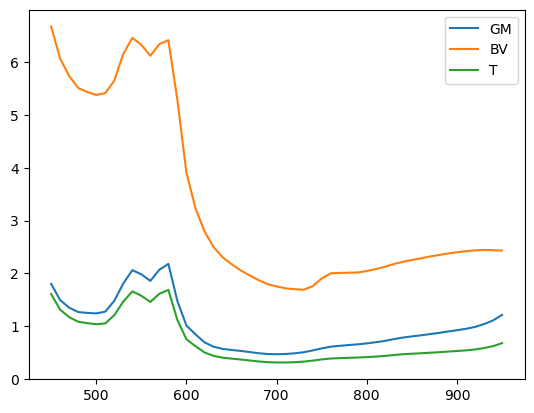

In [12]:
plt.plot(gray_matter_mcs_pathlength_data[:, 0], -np.log(gray_matter_mcs_pathlength_data[:, -3]), label="GM")
plt.plot(blood_vessel_mcs_pathlength_data[:, 0], -np.log(blood_vessel_mcs_pathlength_data[:, -3]), label="BV")
plt.plot(tumor_mcs_pathlength_data[:, 0], -np.log(tumor_mcs_pathlength_data[:, -3]), label="T")
plt.legend()

In [ ]:
bv_thickness = 0.1 #[mm], = voxel size
tissue_depth = 120 #[mm]
tissue_width = 100 #[mm]

In [ ]:
n_voxels_width = int(tissue_width / bv_thickness)
n_voxels_depth = int(tissue_depth / bv_thickness)
print(f"Simulating with {n_voxels_width}^2 x {n_voxels_depth} = {n_voxels_depth * (n_voxels_width**2)} voxels.")

prop = np.array([[0,0,1,1],[0,0,g_gm,refractive_idx_gm],[0,0,g_bv,refractive_idx_bv]])
vol = np.ones((n_voxels_width, n_voxels_width, n_voxels_depth), dtype="uint8")

cfg = {
    "nphoton": 5e7, # higher spatial resolution needs more photons for same noise level
    "maxdetphoton": 5e7,
    "vol": vol,
    "tstart":0,
    "tend":1e-8,
    "tstep":1e-8,
    "autopilot": 1,
    "gpuid": config.gpuid,
    "prop": prop,
    "unitinmm": bv_thickness,
    "bc": "ccrcca001000",
    "isspecular": 1, # should not have effect without 0-voxels
    "srcdir": [0,0,1],
    "srctype": "planar",
    "srcpos": [0, 0, 0],
    "srcparam1": [n_voxels_width, 0, 0, 0], # 3D position of vertex, fourth coordinate is irrelevant
    "srcparam2": [0, n_voxels_width, 0, 0],
    "issrcfrom0": 1,
    "savedetflag": "dpx",
    "flog": str(config.pl_dir) + "/log.txt"
}

#one layer of air
#cfg["vol"][:, :, 0] = 0

# first layer is blood vessel
cfg["vol"][:, :, 0] = 2

In [ ]:
# empty log file
open(config.pl_dir / "log.txt", "w").close()
header_sim = "wavelength gray-matter-mu_a gray-matter-mu_s blood-vessel-mu_a blood-vessel-mu_s diffuse-reflectance gray-matter-pathlength blood-vessel-pathlength total-pl"
with open(config.pl_dir / "blood_vessel_mcs.txt", "w") as f:
    f.write("# " + header_sim + "\n")

data_blood_vessel_mcs = np.empty((len(sample_wavelengths), 9), dtype="float") # per wavelength: wavelength, mu_a, mu_s (1/mm), diffuse reflectance, pathlength (mm)

for i, (wl, mu_a_gm, mu_s_gm, mu_a_bv, mu_s_bv) in enumerate(zip(sample_wavelengths, mu_a_vals_gm, mu_s_vals_gm, mu_a_vals_bv, mu_s_vals_bv)):
    print(f"Simulating for {wl}nm...")
    cfg["prop"][1, 0] = mu_a_gm
    cfg["prop"][1, 1] = mu_s_gm
    cfg["prop"][1, 2] = g_gm
    cfg["prop"][1, 3] = refractive_idx_gm
    cfg["prop"][2, 0] = mu_a_bv
    cfg["prop"][2, 1] = mu_s_bv
    cfg["prop"][2, 2] = g_bv
    cfg["prop"][2, 3] = refractive_idx_bv
    
    res = pmcx.mcxlab(cfg)

    detw = pmcx.utils.detweight(res["detp"])
    dref = np.sum(detw) / cfg["nphoton"]
    pl = pmcx.utils.meanpath(res["detp"])
    data_blood_vessel_mcs[i, :] = np.array([wl, mu_a_gm, mu_s_gm, mu_a_bv, mu_s_bv, dref, pl[0], pl[1], pl[0] + pl[1]])

    with open(config.pl_dir / "blood_vessel_mcs.txt", "ab") as f:
        np.savetxt(f, data_blood_vessel_mcs[[i]])


Interpolate

In [ ]:
assert(np.all(np.diff(dense_wavelengths) > 0))
pl_bv_interpolated_linear = np.interp(dense_wavelengths, sample_wavelengths, data_blood_vessel_mcs[:, -1])
pl_bv_spline_coefs = interpolate.splrep(sample_wavelengths, data_blood_vessel_mcs[:, -1])
pl_bv_interpolated_spline = interpolate.splev(dense_wavelengths, pl_bv_spline_coefs)

Save data to file

In [ ]:
header_interpolations = "wavelength pathlength"

np.savetxt(
    config.pl_dir / "blood_vessel_pl_interpolated_linear.txt",
    np.row_stack((dense_wavelengths, pl_bv_interpolated_linear)).T,
    header=header_interpolations
)

np.savetxt(
    config.pl_dir / "blood_vessel_pl_interpolated_spline.txt",
    np.row_stack((dense_wavelengths, pl_bv_interpolated_spline)).T,
    header=header_interpolations
)

Plot pathlengths

In [ ]:
# Optional load values from file
data_blood_vessel_mcs = np.loadtxt(config.pl_dir / "blood_vessel_mcs.txt")
pl_bv_interpolated_linear = np.loadtxt(config.pl_dir / "blood_vessel_pl_interpolated_linear.txt")[:, 1]
pl_bv_interpolated_spline = np.loadtxt(config.pl_dir / "blood_vessel_pl_interpolated_spline.txt")[:, 1]

In [ ]:
plt.scatter(sample_wavelengths, data_blood_vessel_mcs[:, -1])
plt.plot(dense_wavelengths, pl_bv_interpolated_linear)
plt.plot(dense_wavelengths, pl_bv_interpolated_spline)
plt.plot(dense_wavelengths, pl_gm_interpolated_linear)

### Compute Pathlengths for Tissue with Blood Vessels in Grid Structure (unused, unfinished)

In [ ]:
bv_thickness = 0.1 #[mm], = voxel simulation
bv_area_percentage = 0.0725
tissue_depth = 60 #[mm]
min_total_width = 30 #[mm]
detector_distance = 50 #[mm]

# Find the smallest surface that is evenly divided by grid,
# such that grid has area within desired interval

found = False
for n_voxels_width in range(int(min_total_width / bv_thickness), int(total_depth / bv_thickness + 1)):
    for n_vessels in range(1, int(0.5*(n_voxels_width - 1))):
        if (n_voxels_width - n_vessels) % (n_vessels + 1) != 0:
            continue
        bv_area = 2 * n_vessels * n_voxels_width - n_vessels**2
        cur_bv_area_percentage = bv_area / n_voxels_width**2
        if cur_bv_area_percentage > bv_area_percentage * 1.03:
            break
        if cur_bv_area_percentage > bv_area_percentage * 0.97:
            found = True
            break
        
    if found:
        break
        

if found:
    print(f"Total width [mm]: {n_voxels_width * bv_thickness}")
    print(f"Number of voxels: {n_voxels_width}")
    print(f"Number of vessels (per x/y-dimension, not total): {n_vessels}")
    print(f"Resulting blood vessel area percentage: {cur_bv_area_percentage}")
else:
    print("No value found")

In [ ]:
cfg = {
    "nphoton": 5e7, # higher spatial resolution needs more photons for same noise level
    "maxdetphoton": 5e7,
    "tstart":0,
    "tend":5e-9,
    "tstep":5e-9,
    "autopilot": 1,
    "gpuid": 1,
    "prop": np.array([[0,0,1,1],[0,0,1,1],[0,0,1,1]]),
    "unitinmm": bv_thickness,
    "bc": "ccrcca001000",
    "isspecular": 1, # should not have effect without 0-voxels
    "srcdir": [0,0,1],
    "srctype": "planar",
    "srcpos": [0, 0, 0],
    "srcparam1": [n_voxels_width, 0, 0, 0], # 3D position of vertex, fourth coordinate is irrelevant
    "srcparam2": [0, n_voxels_width, 0, 0],
    "issrcfrom0": 1,
    "savedetflag": "dpx",
    "flog": str(tissue_data_path) + "/log.txt"
}


cfg["vol"] = np.ones((n_voxels_width, n_voxels_width, int((tissue_depth + detector_distance)  / bv_thickness)), dtype="uint8")

# first layer is grid of blood vessels
bv_layer_z_idx = int(np.ceil(detector_distance/bv_thickness))
spacing = int((n_voxels_width - n_vessels) / (n_vessels + 1))
vessel_idxs = list(range(spacing, n_voxels_width, spacing + 1))
bv_pattern = np.zeros((n_voxels_width, n_voxels_width), dtype="bool")
bv_pattern[vessel_idxs, :] = True
bv_pattern[:, vessel_idxs] = True
cfg["vol"][:, :, bv_layer_z_idx:] = 1
cfg["vol"][bv_pattern, bv_layer_z_idx] = 2

In [ ]:
# Find photon (indices) which left bounding box above blood vessels
def split_photon_idxs_by_pattern(detp, pattern):
    photon_pos = np.floor(det["p"][:, :2]).astype(int)
    in_idxs, out_idxs = []
    
    for photon_id in range(detp["detid"].shape[0]):
        x, y = photon_pos[photon_id]
        if bv_pattern[x, y]:
            in_idxs.append(photon_id)
        else:
            out_idxs.append(photon_id)
    
    return in_idxs, out_idxs

# compute weight and mean pathlength of these photons
def compute_weight_idxs(detp, prop, unitinmm, idxs):
    weight = np.ones(len(idxs))

    for i in range(np.array(prop).shape[0]):
        weight = weight * np.exp(-prop[i + 1, 0] * detp["ppath"][idxs, i]) * unitinmm
    
    return weight

def compute_meanpath_idxs(detp, prop, unitinmm, idxs):
    weight = compute_weight_idxs(detp, prop, unitinmm, idxs)
    avgpath = np.sum(
        detp["ppath"][idxs, :] * unitinmm * np.tile(weight, (detp["ppath"].shape[1], 1)).T
    ) / np.sum(weight)

    return avgpath


In [ ]:
# empty log file
open(tissue_data_path / "log.txt", "w").close()

bv_grid_mc_data = np.empty((len(sample_wavelengths), 2), dtype="float") # per wavelength: wavelength, pathlength (mm)
gm_grid_mc_data = np.empty((len(sample_wavelengths), 2), dtype="float") # per wavelength: wavelength, pathlength (mm)

for i, wl in enumerate(sample_wavelengths):
    print(f"Simulating for {wl}nm...")
    mu_a_gm = mu_a_gm_matrix[wl - lower_wavelength]
    mu_s_gm = mu_s_gm_func(wl)
    mu_a_bv = mu_a_bv_matrix[wl - lower_wavelength]
    mu_s_bv = mu_s_bv_func(wl)
    cfg["prop"][1] = np.array([mu_a_gm, mu_s_gm, g_gm, refractive_idx_gm])
    cfg["prop"][2] = np.array([mu_a_bv, mu_s_bv, g_bv, refractive_idx_bv])
    
    res = pmcx.mcxlab(cfg)

    bv_photon_idxs, gm_photon_idxs = split_photon_idxs_by_pattern(res["detp"], bv_pattern)
    bv_meanpath = compute_meanpath_idxs(res["detp"], cfg["prop"], bv_thickness, bv_photon_idxs)
    gm_meanpath = compute_meanpath_idxs(res["detp"], cfg["prop"], bv_thickness, gm_photon_idxs)

    bv_grid_mc_data[i, :] = np.array([wl, bv_meanpath])
    gm_grid_mc_data = np.array([wl, gm_meanpath])